In [1]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt, mpld3
network = pypsa.Network()

pd.set_option("display.max_columns", 30)

In [2]:
#FORMATTING
bus = pd.read_csv('data/base_grid/bus.csv')
sub = pd.read_csv('data/base_grid/sub.csv')
sub = sub.drop(columns = 'interconnect')
bus2sub = pd.read_csv('data/base_grid/bus2sub.csv')
bus2sub = bus2sub.drop(columns = 'interconnect')
buses = bus.merge(bus2sub, how = 'left', on='bus_id')
buses = buses.merge(sub,how='left',on='sub_id')
buses['Va'] = buses['Va'].apply(np.deg2rad)
buses['control'] = buses['type'].map({1:'PQ',2:'PV'})
buses.drop(inplace=True,columns = ['type'])
buses.dropna(subset=['control'],inplace=True)
texas = buses[buses['interconnect'] == 'Texas']
texas = texas.set_index('bus_id')
buses_columns = {'lat':'y',
    'lon':'x',
    'Vm':'v_mag_pu',
    'Pd':'p',
    'Qd':'q',
    'Va':'v_ang',
    'baseKV':'v_nom',
    'Vmax':'v_mag_pu_max',
    'Vmin':'v_mag_pu_min'}

texas = texas.rename(columns = buses_columns)
texas = texas[buses_columns.values()]

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
#ADDING BUSES AND LOADS
for i in range(len(texas)):
    load = texas.iloc[i][3]
    network.add("Bus",texas.index[i], x = texas.iloc[i][1], y = texas.iloc[i][0])
    network.add("Load",texas.index[i], bus = texas.index[i], p_set = load)


In [4]:
#FORMATTING
generators = pd.read_csv('data/base_grid/plant.csv')
cost = pd.read_csv('data/base_grid/gencost.csv')
generators = generators.merge(cost.drop(columns = ['type','interconnect']),how='left',on='plant_id')
generators = generators.merge(bus.drop(columns = ['type', 'interconnect']),how='left',on='bus_id')
generators = generators.merge(bus[['bus_id','type']].rename(columns = {'type':'control'}),how='left',on='bus_id')
texas_generators = generators[generators.interconnect == 'Texas'].copy()
branches = pd.read_csv('data/base_grid/branch.csv')
texas_branches = branches[branches['interconnect'] == 'Texas'].copy()
texas_branches.drop(103363, axis=0, inplace=True)
texas_generators.drop(13253, axis=0, inplace=True)

In [5]:
#ADDING LINES
for i in range(len(texas_branches)):
    name = texas_branches.iloc[i][0]
    busZero = texas_branches.iloc[i][1]
    busOne = texas_branches.iloc[i][2]
    react = texas_branches.iloc[i][4]
    resist = texas_branches.iloc[i][3]
    rateA = texas_branches.iloc[i][6]
    network.add("Line",name,bus0=busZero, bus1=busOne,x=react,r = resist, s_nom = rateA)

#ADDING GENERATORS
texasNamesList = texas.index.values.tolist()
for i in range(len(texas)):
    busLoc = texas.iloc[i][1]
    genList = texas_generators.loc[:,'bus_id'].tolist()
    if texasNamesList[i] in genList:
        pMax = texas_generators.loc[texas_generators['bus_id'] == texasNamesList[i]].iloc[0,9]
        network.add("Generator", i, bus = texasNamesList[i],p_nom = pMax, marginal_cost = 1)

In [6]:
network.pf() 

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning:

Matrix is exactly singular

INFO:pypsa.pf:Newton-Raphson solved in 75 iterations with error of nan in 3.160536 seconds


{'n_iter':       0
 now  75,
 'error':       0
 now NaN,
 'converged':          0
 now  False}

In [7]:
network.lopf(solver_name='cbc',pyomo=False)

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 15.06s
INFO:pypsa.linopf:Solve linear problem using Cbc solver


('warning', 'infeasible')

In [14]:
now = network.snapshots[0]
network.generators_t

{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [now],
 'p_max_pu': Empty DataFrame
 Columns: []
 Index: [now],
 'p_set': Empty DataFrame
 Columns: []
 Index: [now],
 'q_set': Empty DataFrame
 Columns: []
 Index: [now],
 'marginal_cost': Empty DataFrame
 Columns: []
 Index: [now],
 'p':       2    3    5    7    8   10   12   14   15   20   22   25   27   31   32  \
 now NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 
      ...  1917  1918  1925  1926  1937  1953  1954  1955  1967  1968  1969  \
 now  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
 
      1985  1990  1993  1996  
 now   0.0   0.0   0.0   0.0  
 
 [1 rows x 523 columns],
 'q':       2    3    5    7    8   10   12   14   15   20   22   25   27   31   32  \
 now NaN  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 
      ...  1917  1918  1925  1926  1937  1953  1954  1955  1967  1968  1969  \
 now  ...   0.0   0.0   0.0   0.0   0.0   0.0 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pypsa/plot.py:149: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



AttributeError: 'AxesSubplot' object has no attribute 'add_feature'

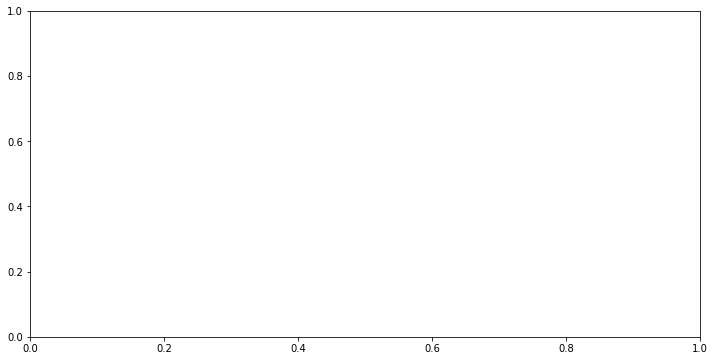

In [9]:
busValue = list(network.buses.index)
lineValue = list(network.lines.index)
color = network.loads.p_set
fig, ax = plt.subplots(figsize=(12, 6))
data = network.plot(bus_colors=color, bus_cmap=plt.cm.RdYlGn, line_widths = 2.0, bus_sizes = .01)

busTooltip = mpld3.plugins.PointHTMLTooltip(data[0], busValue,0,0,-50)
lineTooltip = mpld3.plugins.PointHTMLTooltip(data[1], lineValue, 0, 0, -50)
fileName = "network" + str(3) + ".html"
mpld3.plugins.connect(fig,lineTooltip)
mpld3.plugins.connect(fig,busTooltip)
mpld3.save_html(fig, fileName)